# Changes to MOM executable

After running the CAFE-f6 hindcasts/forecasts, it was discovered that a subset of the hindcasts were run using a version of the MOM executable that produced different behaviour than the other hindcasts/forecasts. The [forecast scripts](https://github.com/csiro-dcfp/cm-forecasts) used whatever MOM executable was available at run time in the directory `/home/548/pas548/src/mom_cafe` (see https://github.com/csiro-dcfp/cm-forecasts/blob/141ea91e095fb6f7285461bc4463ae31ca21801d/settings.sh#L105) and this executable was changed by user `pas548` (Paul Sandery) through time.

## Demonstration of unexpected bevaiour in a subset of the hindcasts

The plot below shows the global mean surface temperature averaged over lead years (where "Lead year 1" corresponds to the average over lead months 0-11, "Lead year 2" corresponds to the average over lead months 12-23 etc). The zig-zagging observed at later leads after 2005 comes about because the forecasts initialised in May (third panel) over this period trend towards a different free-running attractor than the other forecasts.

In [1]:
import os

import glob

import time

import subprocess

import xarray as xr

from src import utils

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

In [3]:
data_dir = "../data/raw/CAFEf6"

files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-*/atmos_isobaric_month.zarr.zip"))


def preprocess(ds):
    ds = utils.convert_time_to_lead(ds)
    ds = utils.truncate_latitudes(ds)
    ds = utils.coarsen(ds, window_size=12, dim="lead")
    return ds


ds = xr.open_mfdataset(
    files,
    compat="override",
    preprocess=preprocess,
    engine="zarr",
    coords="minimal",
)["t_surf"]

ds_gbl = ds.mean("ensemble").weighted(ds["area"]).mean(["lat", "lon"]).compute()

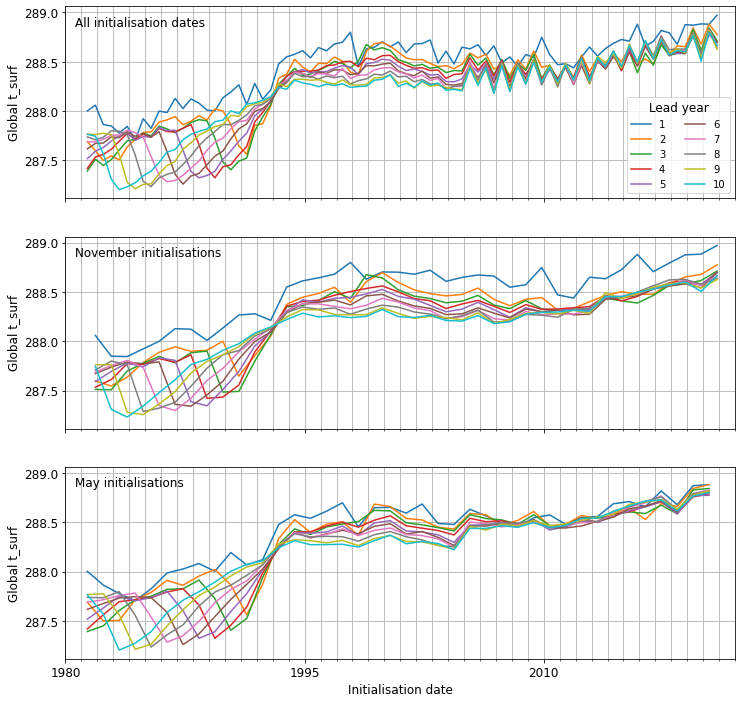

In [4]:
def plot_fig(ds, figsize):
    import matplotlib.pyplot as plt

    ylabel = f"Global {ds.name}"

    fig, (ax0, ax1, ax2) = plt.subplots(
        3,
        1,
        gridspec_kw={
            "height_ratios": [
                1,
                1,
                1,
            ]
        },
        figsize=figsize,
        sharex=True,
    )

    for lead in ds.lead.values:
        label = f"{int((lead+1)/12)}"
        ds.sel(lead=lead).plot.line(ax=ax0, x="init", label=label)

    ax0.legend(ncol=2, title="Lead year", loc="lower right", fontsize=10)

    ylim = ax0.get_ylim()
    ax0.set_title("")
    ax0.set_xlabel("")
    ax0.set_ylabel(ylabel)
    ax0.text(
        0.015,
        0.95,
        "All initialisation dates",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax0.transAxes,
    )
    ticks = xr.cftime_range("1980-01-01", "2022-01-01", freq="AS", calendar="julian")
    xlim = (ticks[0], ticks[-1])
    ax0.set_xticks(ticks.values, minor=True)
    ax0.grid(which="both")
    ax0.set_ylim(ylim)
    ax0.set_xlim(xlim)

    ds[1::2].plot.line(ax=ax1, x="init", add_legend=False)
    ax1.set_xlabel("")
    ax1.set_ylabel(ylabel)
    ax1.text(
        0.015,
        0.95,
        "November initialisations",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax1.transAxes,
    )
    ax1.set_xticks(ticks.values, minor=True)
    ax1.grid(which="both")
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)

    ds[::2].plot.line(ax=ax2, x="init", add_legend=False)
    ax2.set_xlabel("Initialisation date")
    ax2.set_ylabel(ylabel)
    ax2.text(
        0.015,
        0.95,
        "May initialisations",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax2.transAxes,
    )
    ax2.set_xticks(ticks.values, minor=True)
    ax2.grid(which="both")
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)

    return fig


fig = plot_fig(ds_gbl, (12, 12))

## Which forecast executables are different than the current one?

The script `../data/testing/get_forecast_executables_from_tape.sh` retrieves all the CAFE-f6 MOM model executables from tape and stores them in `../data/testing`.

Let's see which CAFE-f6 model executables are the same as a reference executable that was copied from `/home/548/pas548/src/mom_cafe` on 2022-01-25 (the cafe model source code at this point in time can be found here: https://github.com/dougiesquire/mom_cafe/tree/8a1fb1ba0441c094c57ef0e098501f29ae2cb31a)

In [5]:
def mod_time(path):
    return time.strftime("%Y-%m-%d", time.localtime(os.path.getmtime(path)))


forecast_chronology = sorted(
    glob.glob(
        "../data/testing/c5-d60-pX-f6-????????/c5-d60-pX-f6-????????-base/*/*/*/CAFE/forecasts/f6/WIP/c5-d60-pX-f6-????????/MOM/fms_CM2M.x"
    )
)
forecast_chronology = {f: mod_time(f) for f in forecast_chronology}
forecast_chronology = dict(
    sorted(forecast_chronology.items(), key=lambda item: item[1])
)

reference_exectuable = "../data/testing/reference_exectuable/fms_CM2M.x"

In [6]:
def diff(a, b):
    p = subprocess.Popen(["diff", a, b], stdout=subprocess.PIPE)
    res, err = p.communicate()
    if not res:
        return True
    else:
        return False


for e, t in forecast_chronology.items():
    same = diff(e, reference_exectuable)
    if not same:
        print(
            f"{e.split('/')[4]} used a different exectable than the reference executable"
        )

c5-d60-pX-f6-20181101-base used a different exectable than the reference executable
c5-d60-pX-f6-20171101-base used a different exectable than the reference executable
c5-d60-pX-f6-20161101-base used a different exectable than the reference executable
c5-d60-pX-f6-20151101-base used a different exectable than the reference executable
c5-d60-pX-f6-20141101-base used a different exectable than the reference executable
c5-d60-pX-f6-20131101-base used a different exectable than the reference executable
c5-d60-pX-f6-20111101-base used a different exectable than the reference executable
c5-d60-pX-f6-20121101-base used a different exectable than the reference executable
c5-d60-pX-f6-20101101-base used a different exectable than the reference executable
c5-d60-pX-f6-20091101-base used a different exectable than the reference executable
c5-d60-pX-f6-20081101-base used a different exectable than the reference executable
c5-d60-pX-f6-20071101-base used a different exectable than the reference exe

So the majority of the model executables are different that the reference executable.

## When were changes made to the exectuable?

In [7]:
for i in range(len(forecast_chronology) - 1):
    path_1 = list(forecast_chronology.keys())[i]
    path_2 = list(forecast_chronology.keys())[i + 1]
    date_1 = forecast_chronology[path_1]
    date_2 = forecast_chronology[path_2]
    same = diff(path_1, path_2)
    if not same:
        print(f"The executable was changed some time between {date_1} and {date_2}")

The executable was changed some time between 2020-09-25 and 2020-10-08
The executable was changed some time between 2020-10-08 and 2020-10-11
The executable was changed some time between 2020-11-17 and 2020-12-27
The executable was changed some time between 2021-05-07 and 2021-05-15
The executable was changed some time between 2021-06-07 and 2021-06-21


So a number of changes were made to the executable while the forecasts were being run.

## Which forecasts are reproducible with the reference executable? 

To answer this question conclusively, I ended up rerunning, using the reference exectuable, a single member of every forecast that used a different executable than reference executable. The complete set of rerun forecasts are archived on Gadi's tape system, see `mdss -P xv83 dmls -l f6/c5-d60-pX-f6-????????-reproducibility_test`. The `ocean_scalar` model component for each rerun has been retained on spinning disk at `../data/testing/c5-d60-pX-f6-????????-reproducibility_test`. The script `../data/testing/get_reproducibility_data_from_tape.sh` retrieves all the `ocean_scalar` data for the rerun forecasts from tape and stores them in `../data/testing`.

In [8]:
def reproducible(forecast):
    orig_path = "../data/raw/CAFEf6/"
    rerun_path = "../data/testing/"

    rerun_forecast = f"{forecast}-reproducibility_test"

    if os.path.exists(f"{rerun_path}/{rerun_forecast}"):
        orig = xr.open_zarr(f"{orig_path}/{forecast}/ocean_scalar_month.zarr.zip")
        orig = orig["temp_total"].isel(ensemble=0).squeeze()

        rerun = xr.open_mfdataset(
            f"{rerun_path}/{rerun_forecast}/{rerun_forecast}-mem001/scratch/ux06/ds0092/CAFE/forecasts/f6/WIP/{rerun_forecast}/mem001/ocean_scalar_*.nc"
        )
        rerun = rerun["temp_total"].squeeze()

        return all(orig.values == rerun.values)
    else:
        return True


for e in forecast_chronology.keys():
    forecast = e.split("/")[3]
    repro = reproducible(forecast)
    if not repro:
        print(f"{forecast} is not reproducible with the reference executable")

c5-d60-pX-f6-20160501 is not reproducible with the reference executable
c5-d60-pX-f6-20170501 is not reproducible with the reference executable
c5-d60-pX-f6-20130501 is not reproducible with the reference executable
c5-d60-pX-f6-20140501 is not reproducible with the reference executable
c5-d60-pX-f6-20150501 is not reproducible with the reference executable
c5-d60-pX-f6-20120501 is not reproducible with the reference executable
c5-d60-pX-f6-20110501 is not reproducible with the reference executable
c5-d60-pX-f6-20100501 is not reproducible with the reference executable
c5-d60-pX-f6-20090501 is not reproducible with the reference executable
c5-d60-pX-f6-20080501 is not reproducible with the reference executable
c5-d60-pX-f6-20070501 is not reproducible with the reference executable
c5-d60-pX-f6-20060501 is not reproducible with the reference executable
c5-d60-pX-f6-20050501 is not reproducible with the reference executable
c5-d60-pX-f6-20190501 is not reproducible with the reference exe

## Putting this all together

In [9]:
table = (
    "| Forecast name | Forecast run date | Same executable as reference? | Same executable as previous? | Reproducible? \n"
    "| -- | --- | :-: | :-: | :-: | \n"
)

for i in range(len(forecast_chronology)):
    if i == 0:
        path = list(forecast_chronology.keys())[i]
        date = forecast_chronology[path]
        same_as_prev = "-"
    else:
        path_prev = list(forecast_chronology.keys())[i - 1]
        path = list(forecast_chronology.keys())[i]
        date = forecast_chronology[path]
        same = diff(path, path_prev)
        if same:
            same_as_prev = "Y"
        else:
            same_as_prev = "**N**"

    forecast = path.split("/")[3]
    run_date = date

    same = diff(path, reference_exectuable)
    if same:
        same_as_ref = "Y"
    else:
        same_as_ref = "**N**"

    repro = reproducible(forecast)
    if repro:
        repro = "Y"
    else:
        repro = "**N**"

    table += (
        f"| {forecast} | {run_date} | {same_as_ref} | {same_as_prev} | {repro} | \n"
    )

| Forecast name | Forecast run date | Same executable as reference? | Same executable as previous? | Reproducible? 
| -- | --- | :-: | :-: | :-: | 
| c5-d60-pX-f6-20181101 | 2020-07-07 | **N** | - | Y | 
| c5-d60-pX-f6-20171101 | 2020-07-21 | **N** | Y | Y | 
| c5-d60-pX-f6-20161101 | 2020-07-29 | **N** | Y | Y | 
| c5-d60-pX-f6-20151101 | 2020-08-05 | **N** | Y | Y | 
| c5-d60-pX-f6-20141101 | 2020-08-10 | **N** | Y | Y | 
| c5-d60-pX-f6-20131101 | 2020-08-14 | **N** | Y | Y | 
| c5-d60-pX-f6-20111101 | 2020-08-18 | **N** | Y | Y | 
| c5-d60-pX-f6-20121101 | 2020-08-18 | **N** | Y | Y | 
| c5-d60-pX-f6-20101101 | 2020-08-24 | **N** | Y | Y | 
| c5-d60-pX-f6-20091101 | 2020-08-26 | **N** | Y | Y | 
| c5-d60-pX-f6-20081101 | 2020-09-01 | **N** | Y | Y | 
| c5-d60-pX-f6-20071101 | 2020-09-10 | **N** | Y | Y | 
| c5-d60-pX-f6-20061101 | 2020-09-11 | **N** | Y | Y | 
| c5-d60-pX-f6-20051101 | 2020-09-25 | **N** | Y | Y | 
| c5-d60-pX-f6-20180501 | 2020-10-08 | **N** | **N** | Y | 
| c5-d60-pX-f6-20160501 | 2020-10-11 | **N** | **N** | **N** | 
| c5-d60-pX-f6-20170501 | 2020-10-11 | **N** | Y | **N** | 
| c5-d60-pX-f6-20130501 | 2020-10-14 | **N** | Y | **N** | 
| c5-d60-pX-f6-20140501 | 2020-10-14 | **N** | Y | **N** | 
| c5-d60-pX-f6-20150501 | 2020-10-14 | **N** | Y | **N** | 
| c5-d60-pX-f6-20120501 | 2020-10-23 | **N** | Y | **N** | 
| c5-d60-pX-f6-20110501 | 2020-10-24 | **N** | Y | **N** | 
| c5-d60-pX-f6-20100501 | 2020-10-28 | **N** | Y | **N** | 
| c5-d60-pX-f6-20090501 | 2020-10-29 | **N** | Y | **N** | 
| c5-d60-pX-f6-20080501 | 2020-10-30 | **N** | Y | **N** | 
| c5-d60-pX-f6-20070501 | 2020-11-01 | **N** | Y | **N** | 
| c5-d60-pX-f6-20060501 | 2020-11-02 | **N** | Y | **N** | 
| c5-d60-pX-f6-20050501 | 2020-11-12 | **N** | Y | **N** | 
| c5-d60-pX-f6-20190501 | 2020-11-16 | **N** | Y | **N** | 
| c5-d60-pX-f6-20200501 | 2020-11-17 | **N** | Y | **N** | 
| c5-d60-pX-f6-20201101 | 2020-12-27 | **N** | **N** | Y | 
| c5-d60-pX-f6-20021101 | 2021-02-09 | **N** | Y | Y | 
| c5-d60-pX-f6-20031101 | 2021-02-09 | **N** | Y | Y | 
| c5-d60-pX-f6-20041101 | 2021-02-09 | **N** | Y | Y | 
| c5-d60-pX-f6-20011101 | 2021-02-13 | **N** | Y | Y | 
| c5-d60-pX-f6-20001101 | 2021-02-17 | **N** | Y | Y | 
| c5-d60-pX-f6-19981101 | 2021-02-18 | **N** | Y | Y | 
| c5-d60-pX-f6-19991101 | 2021-02-18 | **N** | Y | Y | 
| c5-d60-pX-f6-19951101 | 2021-02-23 | **N** | Y | **N** | 
| c5-d60-pX-f6-19961101 | 2021-02-23 | **N** | Y | Y | 
| c5-d60-pX-f6-19971101 | 2021-02-23 | **N** | Y | Y | 
| c5-d60-pX-f6-19941101 | 2021-02-28 | **N** | Y | Y | 
| c5-d60-pX-f6-19921101 | 2021-03-22 | **N** | Y | Y | 
| c5-d60-pX-f6-19931101 | 2021-03-22 | **N** | Y | Y | 
| c5-d60-pX-f6-19911101 | 2021-03-24 | **N** | Y | Y | 
| c5-d60-pX-f6-19901101 | 2021-03-25 | **N** | Y | Y | 
| c5-d60-pX-f6-19891101 | 2021-03-28 | **N** | Y | Y | 
| c5-d60-pX-f6-19861101 | 2021-04-01 | **N** | Y | Y | 
| c5-d60-pX-f6-19871101 | 2021-04-01 | **N** | Y | Y | 
| c5-d60-pX-f6-19881101 | 2021-04-01 | **N** | Y | Y | 
| c5-d60-pX-f6-19841101 | 2021-04-13 | **N** | Y | Y | 
| c5-d60-pX-f6-19851101 | 2021-04-13 | **N** | Y | Y | 
| c5-d60-pX-f6-19811101 | 2021-04-21 | **N** | Y | Y | 
| c5-d60-pX-f6-19821101 | 2021-04-21 | **N** | Y | Y | 
| c5-d60-pX-f6-19831101 | 2021-04-21 | **N** | Y | Y | 
| c5-d60-pX-f6-20020501 | 2021-04-26 | **N** | Y | Y | 
| c5-d60-pX-f6-20030501 | 2021-04-26 | **N** | Y | Y | 
| c5-d60-pX-f6-20040501 | 2021-04-26 | **N** | Y | Y | 
| c5-d60-pX-f6-20000501 | 2021-05-02 | **N** | Y | Y | 
| c5-d60-pX-f6-20010501 | 2021-05-02 | **N** | Y | Y | 
| c5-d60-pX-f6-19970501 | 2021-05-07 | **N** | Y | Y | 
| c5-d60-pX-f6-19980501 | 2021-05-07 | **N** | Y | Y | 
| c5-d60-pX-f6-19990501 | 2021-05-07 | **N** | Y | Y | 
| c5-d60-pX-f6-19950501 | 2021-05-15 | **N** | **N** | Y | 
| c5-d60-pX-f6-19960501 | 2021-05-15 | **N** | Y | Y | 
| c5-d60-pX-f6-19940501 | 2021-05-16 | **N** | Y | Y | 
| c5-d60-pX-f6-19920501 | 2021-06-02 | **N** | Y | Y | 
| c5-d60-pX-f6-19930501 | 2021-06-02 | **N** | Y | Y | 
| c5-d60-pX-f6-19900501 | 2021-06-07 | **N** | Y | Y | 
| c5-d60-pX-f6-19910501 | 2021-06-07 | **N** | Y | Y | 
| c5-d60-pX-f6-19870501 | 2021-06-21 | Y | **N** | Y | 
| c5-d60-pX-f6-19880501 | 2021-06-21 | Y | Y | Y | 
| c5-d60-pX-f6-19890501 | 2021-06-21 | Y | Y | Y | 
| c5-d60-pX-f6-19860501 | 2021-06-28 | Y | Y | Y | 
| c5-d60-pX-f6-19850501 | 2021-07-18 | Y | Y | Y | 
| c5-d60-pX-f6-19840501 | 2021-08-03 | Y | Y | Y | 
| c5-d60-pX-f6-19830501 | 2021-08-12 | Y | Y | Y | 
| c5-d60-pX-f6-19820501 | 2021-09-17 | Y | Y | Y | 
| c5-d60-pX-f6-19810501 | 2021-11-10 | Y | Y | Y | 
| c5-d60-pX-f6-20191101 | 2022-01-28 | Y | Y | Y | 

All May forecasts from 2005-05-01 to 2020-05-01, excluding 2018-05-01, are not reproducible. I spent some time with Paul Sandery (who changed the executable) trying to establish what exactly was different about the executable for these forecasts. Unfortunately, Paul did not `git commit` the changes he was making to the repo containing the executable (https://bitbucket.csiro.au/projects/DF/repos/mom_cafe/browse; Internal CSIRO only) so there is no record of what changed.

Paul thought that the main changes he made to the MOM source code around the problem period were in `ice_dyn.F90`. In particular, Paul flagged line 250 of `ice_dyn.F90` as one he had changed.

For the reference executable (see https://github.com/dougiesquire/mom_cafe/blob/8a1fb1ba0441c094c57ef0e098501f29ae2cb31a/src/ice_sis/ice_dyn.F90), line 250 reads:
``` fortran
if( (wett(i,j)>0.5) .and.(ci(i,j)*(DI*hi(i,j)+DS*hs(i,j))>MIV_MIN) .and. (edt(i,j)>0) ) then
```

Paul provided two new executables, compiled with

**a)**
``` fortran
if( (wett(i,j)>0.5) .and.(ci(i,j)*(DI*hi(i,j)+DS*hs(i,j))>MIV_MIN) ) then
```

**b)**
``` fortran
if( (wett(i,j)>0.5) .and.(ci(i,j)*(DI*hi(i,j)+DS*hs(i,j))>MIV_MIN) .and. (edt(i,j)>0) .and. (strn11(i,j)>0) .and. (strn22(i,j)>0) ) then
```

The former (**a**) is what is in the original [MOM5 repo](https://github.com/mom-ocean/MOM5/blob/9b8ec93983a54e4b8d9d148eb6863b8ac94fbce3/src/ice_sis/ice_dyn.F90#L249). The latter (**b**) is a change that Paul thinks he may have made at some point.

I ran test runs with each of these new executables to see if either reproduces the behaviour of the problem May forecasts. Change **a** produced results identical to those produced by the reference executable. Change **b** produced results that are different than both those produced by the reference executable and those produced by the executable used for the problem May forecasts.

These runs are archived on Gadi tape storage:
- Rerun of 2006-05-01 using reference executable: `mdss -P xv83 dmls -l f6/c5-d60-pX-f6-20060501-rerun`
- Rerun of 2006-05-01 using executable compiled with **a**: `mdss -P xv83 dmls -l f6/c5-d60-pX-f6-20060501-ORIG_ice_dyn.F90`
- Rerun of 2006-05-01 using executable compiled with **b**: `mdss -P xv83 dmls -l f6/c5-d60-pX-f6-20060501-TRANSIENT_ice_dyn.F90`
- Rerun of 2006-05-01 using executable from 2020-11-02: `mdss -P xv83 dmls -l f6/c5-d60-pX-f6-20060501-rerun-oldexec`

**Until we can work out exactly what was changed to produce the problem May forecasts, the approach in this project is to use only the November-initialised forecasts.**

## Why is c5-d60-pX-f6-19951101 not reproducible?
c5-d60-pX-f6-19951101 is not reproducible, but this forecast was not run during the period when the model executable was inconsistent. Let's take a look at what's different between the original run and the reproducibility run.

In [10]:
orig = (
    xr.open_zarr(
        "../data/raw/CAFEf6/c5-d60-pX-f6-19951101/ocean_scalar_month.zarr.zip"
    )["temp_total"]
    .isel(ensemble=0)
    .squeeze()
)

rerun = xr.open_mfdataset(
    "../data/testing/c5-d60-pX-f6-19951101-reproducibility_test/c5-d60-pX-f6-19951101-reproducibility_test-mem001/scratch/ux06/ds0092/CAFE/forecasts/f6/WIP/c5-d60-pX-f6-19951101-reproducibility_test/mem001/ocean_scalar_*.nc"
)["temp_total"].squeeze()

difference = orig - rerun

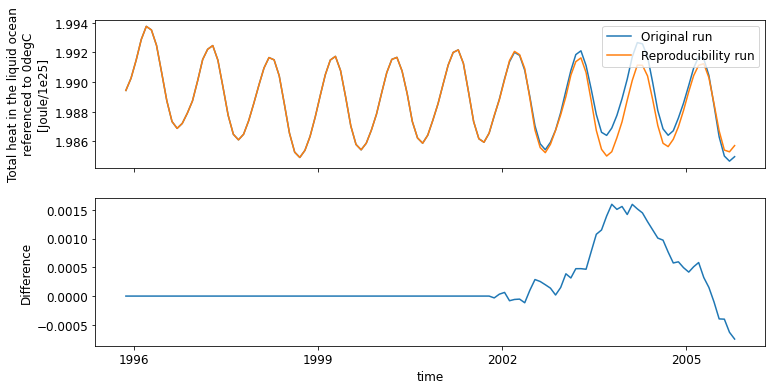

In [11]:
fig, (ax0, ax1) = plt.subplots(
    2,
    1,
    sharex=True,
)

orig.plot(ax=ax0, label="Original run")
rerun.plot(ax=ax0, label="Reproducibility run")
ax0.legend()
ax0.set_xlabel("")
ax0.set_title("")

difference.plot(ax=ax1, label="Difference")
ax1.set_ylabel("Difference")
_ = ax1.set_title("")

These start to deviate in the 71st month of the forecast. But both forecasts were run as single cycle, so I don't really understand how this could happen. Is it possible that something external changed (e.g. the forcing files or Gadi itself)? This doesn't seem that plausible to me...